In [1]:
import importlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from argparse import Namespace
from logging import warning
import os.path as osp
import numpy as np

from torch_geometric.graphgym.config import cfg, dump_cfg, set_cfg, load_cfg
from torch_geometric.graphgym.loader import create_loader
from torch_geometric.graphgym.model_builder import create_model
from torch_geometric.graphgym.loss import compute_loss

from graphgps.finetuning import load_pretrained_model_cfg, init_model_from_pretrained

/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
gps_none_test_accs = [0.7103, 0.7130, 0.7084, 0.7132, 0.7118]
params = 249880
print(np.mean(gps_none_test_accs), np.std(gps_none_test_accs), params)

random_sparse_test_accs = [0.7099, 0.7059, 0.7063, 0.7104, 0.7153]
params = 296696
print(np.mean(random_sparse_test_accs), np.std(random_sparse_test_accs), params)

0.7113400000000001 0.001797331355092845 249880
0.70956 0.00339976469774014 296696


In [3]:
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

11.3
False
True


In [4]:
# CONFIGURATION

dataset = 'Cifar10'

args = Namespace(
    cfg_file = f'configs/Small-experiment/{dataset}/GPS+SparseAttention.yaml',
    repeat = 1,
    mark_done = False,
    opts=[],
)

set_cfg(cfg)
load_cfg(cfg, args)
dump_cfg(cfg)

# Adapt configuration
if hasattr(cfg, 'pretrained_dir'):
    warning.warn(f"cfg has pretrained_dir {cfg.pretrained_dir}, which we are not using")
cfg.pretrained.dir = f'results/{dataset}/GPS+SparseAttention/'   # None to use random initialization
if cfg.device == 'auto':
    cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {cfg.device}")

cfg = load_pretrained_model_cfg(cfg)

# Set Pytorch environment
torch.set_num_threads(cfg.num_threads)

Using device: cpu


In [5]:
# LOADER
loaders = create_loader()

loader = loaders[0]
split = 'test'

100%|██████████| 60000/60000 [02:24<00:00, 415.59it/s]


In [6]:
# MODEL
model = create_model()
if cfg.pretrained.dir:
    model = init_model_from_pretrained(
        model, cfg.pretrained.dir, freeze_main=False,
        reset_prediction_head=False, device=cfg.device
    )


model.eval()

GPSModel(
  (encoder): FeatureEncoder(
    (node_encoder): Concat2NodeEncoder(
      (encoder1): LinearNodeEncoder(
        (encoder): Linear(in_features=5, out_features=40, bias=True)
      )
      (encoder2): EquivStableLapPENodeEncoder(
        (linear_encoder_eigenvec): Linear(in_features=8, out_features=40, bias=True)
      )
    )
    (edge_encoder): LinearEdgeEncoder(
      (encoder): Linear(in_features=1, out_features=40, bias=True)
    )
  )
  (layers): Sequential(
    (0): GPSLayer(
      summary: dim_h=40, local_gnn_type=CustomGatedGCN, global_model_type=SparseAttention, heads=4
      (local_model): GatedGCNLayer()
      (self_attn): SparseAttention(
        (MQs): Linear(in_features=40, out_features=160, bias=True)
        (MKs): Linear(in_features=40, out_features=160, bias=True)
        (MVs): Linear(in_features=40, out_features=160, bias=True)
        (MO): Linear(in_features=160, out_features=40, bias=True)
      )
      (norm1_local): BatchNorm1d(40, eps=1e-05, momentu

In [7]:
print(len(loaders))
# print(len(loggers))
print(loaders[0].dataset.data.x.shape)
print(loaders[0].dataset.data.y.shape)
print(loaders[1].dataset.data.x.shape)
print(loaders[1].dataset.data.y.shape)
print(loaders[2].dataset.data.x.shape)
print(loaders[2].dataset.data.y.shape)

# find the difference between the two loaders
print(torch.all(loaders[0].dataset.data.x == loaders[2].dataset.data.x))
print(torch.all(loaders[0].dataset.data.y == loaders[2].dataset.data.y))


3
torch.Size([7058005, 5])
torch.Size([60000])
torch.Size([7058005, 5])
torch.Size([60000])
torch.Size([7058005, 5])
torch.Size([60000])
tensor(True)
tensor(True)


In [8]:
from graphgps.loss.subtoken_prediction_loss import subtoken_cross_entropy

def arxiv_cross_entropy(pred, true, split_idx):
    true = true.squeeze(-1)
    if pred.ndim > 1 and true.ndim == 1:
        pred_score = F.log_softmax(pred[split_idx], dim=-1)
        loss =  F.nll_loss(pred_score, true[split_idx])
    else:
        raise ValueError("In ogbn cross_entropy calculation dimensions did not match.")
    return loss, pred_score

loader = loaders[0]
split = 'test'

i = -1
for batch in loader:
    i += 1
    if i%20 == 0:
        print("processing batch", i)
    batch.split = split
    
    if cfg.gnn.head == 'inductive_edge':
        pred, true, extra_stats = model(batch)
    else:
        pred, true = model(batch)
        extra_stats = {}
    
    if cfg.dataset.name == 'ogbg-code2':
        loss, pred_score = subtoken_cross_entropy(pred, true)
        _true = true
        _pred = pred_score
    elif cfg.dataset.name == 'ogbn-arxiv':
        index_split = loader.dataset.split_idx[split].to(torch.device(cfg.device))
        loss, pred_score = arxiv_cross_entropy(pred, true, index_split)
        _true = true[index_split].detach().to('cpu', non_blocking=True)
        _pred = pred_score.detach().to('cpu', non_blocking=True)
    else:
        loss, pred_score = compute_loss(pred, true)
        _true = true.detach().to('cpu', non_blocking=True)
        _pred = pred_score.detach().to('cpu', non_blocking=True)

In [9]:
# What could we want to plot?
# - visualize graphs
# - homophily metric
# - correspondence with given graph
# - how does this all work when using multiple heads?


# lists of length num_graphs, containing tensors of shape (num_tokens, num_features)
# tokens: num_graphs, (num_tokens, num_features)
# labels: num_graphs, (num_tokens,)


from typing import Callable, Dict

from graphgps.layer.gps_layer import GPSLayer


class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.tokens = {}
        self.labels = {}
        self.edge_idxs = []
        self.attn_layers = {}
        self.hooks = []

        for name, module in model.named_modules():
            if isinstance(module, GPSLayer):
                self.hooks.append(
                    module.self_attn.register_forward_hook(
                        self.save_tokens_labels_hook(name, module.global_model_type)
                    )
                )
                self.tokens[name] = []
                self.labels[name] = []
                self.attn_layers[name] = module.self_attn

    def save_tokens_labels_hook(self, layer_name: str, global_model_type: str) -> Callable:
        def hook(module: nn.Module, input, output):
            if global_model_type in ('Transformer',):
                # input is 3-tuple (x,x,x)
                # output is a tuple (output, None)
                assert type(input) == type(output) == tuple, f"input: {type(input)}\noutput: {type(output)}"
                assert len(input) == 3 and len(output) == 2, f"input: {len(input)}\noutput: {len(output)}"
                input = input[0]
                output = output[0]
            
            elif global_model_type in ('SparseAttention',):
                assert type(input) == tuple, f"input: {type(input)}"
                global mymodule
                mymodule = module
                global myinput
                myinput = input
                global myoutput
                myoutput = output
                assert len(input) == 1, f"input: {len(input)}"
                assert type(output) == torch.Tensor, f"output: {type(output)}"
                input = input[0]

            elif global_model_type in ['Performer', 'BigBird']:
                pass

            # input: (batch_size, num_tokens, num_features)
            assert input.ndim == 3
            assert output.ndim == 3
            B = input.shape[0]
            for b in range(B):
                self.tokens[layer_name].append(input[b])
                self.labels[layer_name].append(output[b])
        return hook
    
    def remove_all_hooks(self):
        for hook in self.hooks:
            hook.remove()

# to ensure that the hooks are removed when we re-run this cell
if 'myFeatureExtractor' in locals():
    myFeatureExtractor.remove_all_hooks()

myFeatureExtractor = FeatureExtractor(model)

for name, module in model.named_modules():
    for key, hook in module._forward_hooks.items():
        print(name, ":", key, hook)

layers.0.self_attn : 27 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7f7076823c10>
layers.1.self_attn : 28 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7f7076316ee0>
layers.2.self_attn : 29 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7f7076316af0>
layers.3.self_attn : 30 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7f7076316940>
layers.4.self_attn : 31 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7f70762f7f70>


In [10]:
# run the model on the first 100 graphs, and save the tokens and labels

from graphgps.utils import batch_to_edge_idxs


num_graphs = 0
for i, batch in enumerate(loader):
    batch.split = 'test'
    if num_graphs > 200:
        break
    num_graphs += batch.num_graphs
    print("processing batch", i, "-", num_graphs)

    edge_idxs = batch_to_edge_idxs(batch)
    assert len(edge_idxs) == batch.num_graphs
    for b in range(batch.num_graphs):
        myFeatureExtractor.edge_idxs.append(edge_idxs[b])

    pred, true = model(batch)

processing batch 0 - 16
processing batch 1 - 32
processing batch 2 - 48
processing batch 3 - 64
processing batch 4 - 80
processing batch 5 - 96
processing batch 6 - 112
processing batch 7 - 128
processing batch 8 - 144
processing batch 9 - 160
processing batch 10 - 176
processing batch 11 - 192
processing batch 12 - 208


In [11]:
for layer in myFeatureExtractor.tokens.keys():
    print(layer, len(myFeatureExtractor.tokens[layer]), len(myFeatureExtractor.labels[layer]), len(myFeatureExtractor.edge_idxs))

layers.0 208 208 208
layers.1 208 208 208
layers.2 208 208 208
layers.3 208 208 208
layers.4 208 208 208


Text(-0.1, 0.5, 'MyTitle')

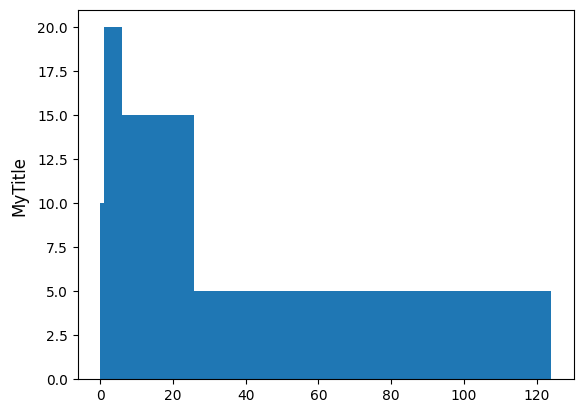

In [12]:
import matplotlib.pyplot as plt

# fill each of the ranges with 100 elements
data = [0] * 10 + list(range(1,6)) * 20 + list(range(6,26)) * 15 + list(range(26, 125)) * 5

# this generates the attached picture
plt.hist(data, bins=max(data)+1)
plt.title("MyTitle", rotation=90, x=-0.1, y=0.5, va='center', ha='right')

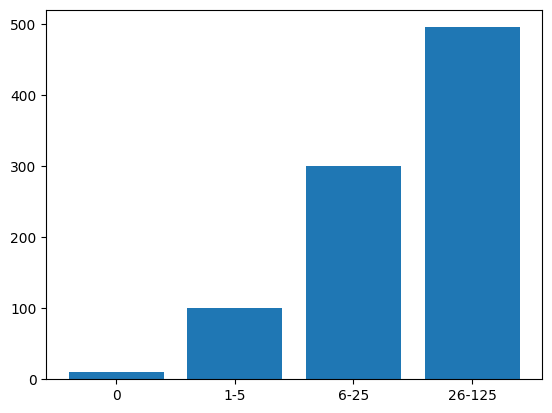

In [13]:
bar0 = sum(d==0 for d in data)
bar1_5 = sum(1 <= d <= 5 for d in data)
bar6_25 = sum(6 <= d <= 25 for d in data)
bar26_ = sum(26 <= d for d in data)

# Plotting the histogram
bars = ['0', '1-5', '6-25', '26-125']
heights = [bar0, bar1_5, bar6_25, bar26_]

plt.bar(bars, heights)
plt.show()

number of computed graphs: 208
number of graphs used for display: 200
processing layer 0
processing layer 1
processing layer 2
processing layer 3
processing layer 4


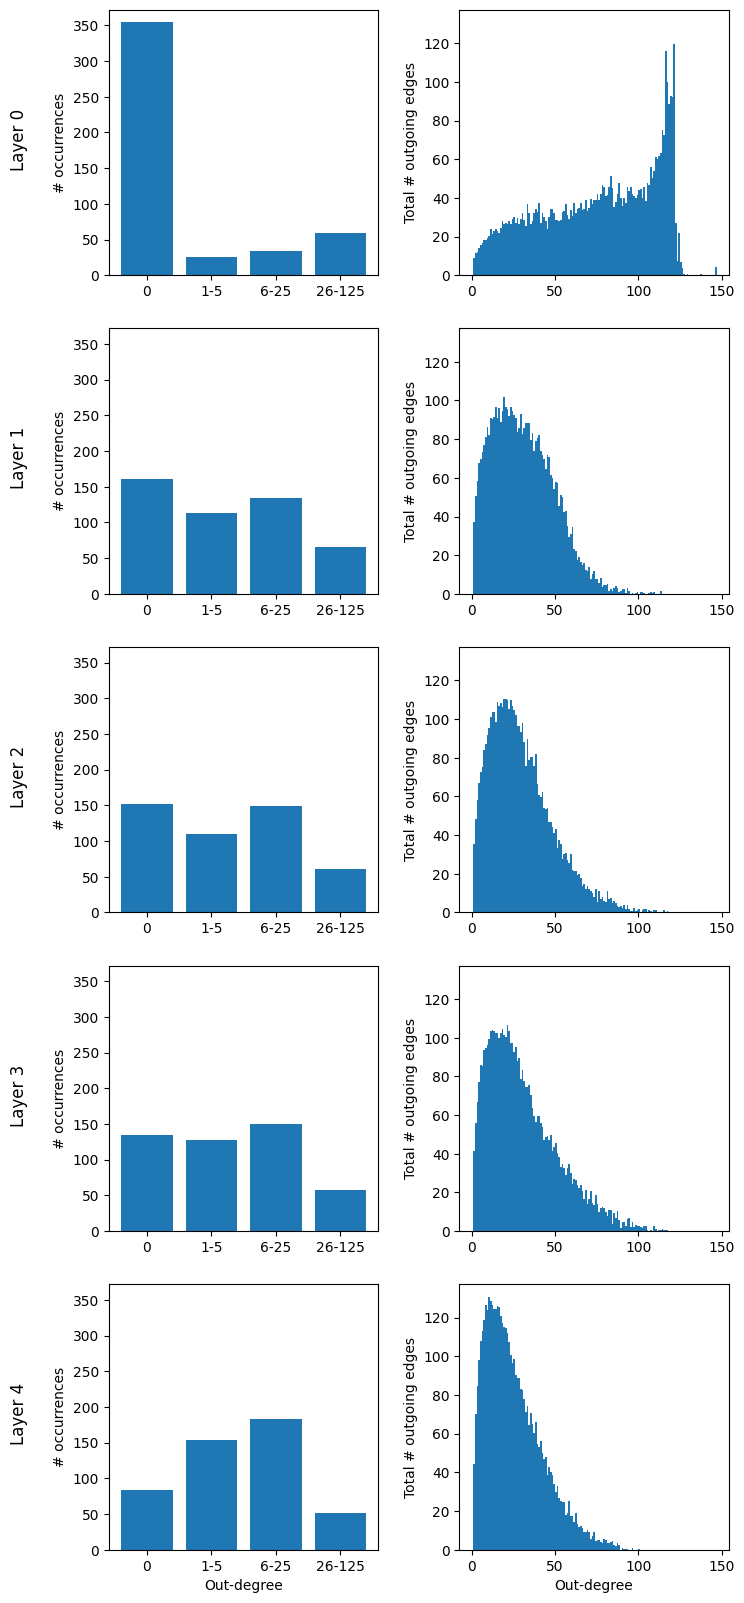

In [14]:
num_computed_graphs = len(myFeatureExtractor.edge_idxs)
num_display_graphs = 200
print("number of computed graphs:", num_computed_graphs)
print("number of graphs used for display:", num_display_graphs)
assert num_display_graphs <= num_computed_graphs

import math
from graphgps.layer.sparse_attention_layer import SparseAttention

from matplotlib import pyplot as plt

# prepare figure for plotting out degree statistics
fig_od, axs_od = plt.subplots(5, 2, figsize=(8,20), sharey='col', sharex='col')
plt.subplots_adjust(hspace=0.2, wspace=0.3)
axs_od[-1,0].set_xlabel("Out-degree")
axs_od[-1,1].set_xlabel("Out-degree")
for row in range(5):
    # axs[row,0].set_xlabel("Out-degree")
    axs_od[row,0].set_ylabel("# occurrences")
    axs_od[row,0].xaxis.set_tick_params(labelbottom=True)

    # axs[row,1].set_xlabel("Out-degree")
    axs_od[row,1].set_ylabel("Total # outgoing edges")
    axs_od[row,1].xaxis.set_tick_params(labelbottom=True)


edge_idxs = myFeatureExtractor.edge_idxs
for layer_name in myFeatureExtractor.tokens.keys():
    token_list = myFeatureExtractor.tokens[layer_name]  # list of tensors, one for each graph
    label_list = myFeatureExtractor.labels[layer_name]  # list of tensors, one for each graph
    attn = myFeatureExtractor.attn_layers[layer_name]

    layer_num = int(layer_name.split('.')[-1])
    print("processing layer", layer_num)
    
    if isinstance(attn, SparseAttention):
        occurrences_counts = []
        num_heads = attn.num_heads

        for x in token_list[:num_display_graphs]:
            
            # [1, N, dim]
            x = x.unsqueeze(0)

            # [1, num_heads, N, kq_dim]
            queries = attn.split_heads(attn.MQs(x), small_dim=attn.kq_dim)
            keys = attn.split_heads(attn.MKs(x), small_dim=attn.kq_dim)
            # [1, num_heads, N, val_dim]
            values = attn.split_heads(attn.MVs(x), small_dim=attn.val_dim)

            # [1, num_heads, N, k]
            nearest_key_indices = attn.nearest_k_keys(queries, keys)

            # the k keys nearest to each query
            # [1, num_heads, N, k, kq_dim]
            nearest_keys = torch.gather(
                input=keys.unsqueeze(-2).expand(
                    *keys.shape[:-1], attn.k, attn.kq_dim
                ),  # [**, num_heads, N, k, kq_dim]
                dim=-3,
                index=nearest_key_indices.unsqueeze(-1).expand(
                    *nearest_key_indices.shape, attn.kq_dim
                ),  # [**, num_heads, N, k, kq_dim]
                # sparse_grad=True,
            )

            # [1, num_heads, N, k, kq_dim]
            queries_extended = queries.unsqueeze(-2).expand(
                *queries.shape[:-1], attn.k, attn.kq_dim
            )

            # [1, num_heads, N, k]
            largest_attention_weights = (queries_extended * nearest_keys).sum(
                -1
            ) / math.sqrt(attn.kq_dim)

            fake_keys = largest_attention_weights[0][0].norm(dim=-1) == largest_attention_weights[0][0].norm(dim=-1)[-1]
            num_real_keys = len(nearest_key_indices[0][0][~fake_keys])
            for h in range(num_heads):
                # save number of occurrences of each out-degree value
                occurrences_counts.append(torch.bincount(nearest_key_indices[0][h][~fake_keys].flatten(), minlength=num_real_keys))

    occurrences_counts = torch.cat(occurrences_counts, dim=0)
    
    bar0 = sum(d==0 for d in occurrences_counts) / num_display_graphs
    bar1_5 = sum(1 <= d <= 5 for d in occurrences_counts) / num_display_graphs
    bar6_25 = sum(6 <= d <= 25 for d in occurrences_counts) / num_display_graphs
    bar26_ = sum(26 <= d for d in occurrences_counts) / num_display_graphs

    # Plotting the histogram
    bars = ['0', '1-5', '6-25', '26-125']
    heights = [bar0, bar1_5, bar6_25, bar26_]

    axs_od[layer_num,0].bar(bars, heights)

    axs_od[layer_num,1].hist(occurrences_counts, bins=torch.arange(0, max(occurrences_counts)+1), weights=occurrences_counts / num_display_graphs)
    axs_od[layer_num,0].set_title(f"Layer {layer_num}", rotation=90, x=-0.3, y=0.48, va='center', ha='right')

plt.show()

# plt.hist(nearest_key_indices[0][0].flatten(), bins=100)
# plt.scatter(x=torch.arange(0,len(keys[0][0])), y=keys[0][0].detach().norm(dim=-1).flatten(), c='r', s=0.7)

In [15]:
import networkx as nx

def vis_mip_attn_graph_multiple_heads(pos, axs, nearest_key_indices, largest_attention_weights, norm_node, cmap_node):
    """
    args:
        axs: [1, num_heads] row of axes to plot on
        nearest_key_indices: [num_heads, N, k]. nearest_key_indices[h][i][m]==j signifies there is an edge from j to i in head h.
    """

    H, N, k = nearest_key_indices.shape

    # plotting stuff
    norm_edge = plt.Normalize(vmin=largest_attention_weights.min(), vmax=largest_attention_weights.max())
    cmap_edge = plt.cm.plasma

    for h in range(H):
        print(f"head {h+1}/{H}")
        ax = axs[h]
        vis_mip_attn_graph(pos, nearest_key_indices[h], largest_attention_weights[h], ax=ax, norm_edge=norm_edge, cmap_edge=cmap_edge, norm_node=norm_node, cmap_node=cmap_node)
        # ax.set_title(f"Head {h+1}") # caption above
        # axs[h].text(0.5, -0.05, f"Head {h+1}", ha='center', va='center', transform=axs[h].transAxes, fontsize=20*height/5)  # caption below



def vis_mip_attn_graph(pos, nearest_key_indices, largest_attention_weights, ax: plt.Axes, norm_edge: plt.Normalize, cmap_edge: plt.cm, norm_node: plt.Normalize, cmap_node: plt.cm):
    """
    args:
        nearest_key_indices: [N, k]. nearest_key_indices[i][m]==j signifies there is an edge from j to i in head h.
    """

    out_degrees = torch.bincount(nearest_key_indices.flatten(), minlength=nearest_key_indices.shape[0]+1)

    N, k = nearest_key_indices.shape
    G = nx.DiGraph()
    for i in range(N):
        for m in range(k):
            if nearest_key_indices[i][m].item() >= N:   # throw away fake keys
                continue
            if i >= N:
                raise Exception("this should not happen")
            weight = largest_attention_weights[i][m].item()
            G.add_edge(nearest_key_indices[i][m].item(), i, weight=weight)

    # get weights and map to colors
    weights = nx.get_edge_attributes(G, 'weight')
    edge_colors = [cmap_edge(norm_edge(weights[edge])) for edge in G.edges()]
    edge_alphas = [norm_edge(weights[edge]) for edge in G.edges()]
    node_colors = [cmap_node(norm_node(out_degrees[i])) for i in list(G)]
    node_labels = {i: out_degrees[i].item() for i in range(N)}

    # draw the graph with edge colors
    # nx.draw_networkx_edges(input_graph, pos, edge_color='black', width=1, ax=ax)
    nx.draw_networkx_edges(G, pos, node_size=20, alpha=edge_alphas, width=.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=20, ax=ax, node_color=node_colors)
    # nx.draw_networkx_labels(G, pos, font_size=4, ax=ax, labels=node_labels)

    return G

In [16]:
myFeatureExtractor.tokens.keys()
myFeatureExtractor.tokens['layers.0'][0].shape
x = myFeatureExtractor.tokens['layers.0'][0]
x[:5]

tensor([[ 5.5894e-02, -1.6244e-01,  4.2094e-02, -1.2568e-01, -7.1941e-02,
          1.8588e-01,  2.2016e-01,  6.6029e-02,  8.9216e-02,  4.0519e-03,
         -1.5006e-01,  6.9518e-02,  1.1293e-02, -1.6248e-01, -1.9279e-01,
          1.6663e-01, -2.7870e-01, -5.1397e-03,  2.5365e-01, -8.3765e-03,
         -4.7032e-02,  2.5951e-01, -1.2759e-01,  3.9032e-02,  5.1844e-02,
          1.1930e-01, -8.4483e-02, -1.8419e-01, -5.2997e-02,  1.9666e-01,
          3.0746e-02,  2.8501e-01,  1.5790e-01,  3.1518e-02,  9.9984e-03,
          1.3432e-01, -2.1922e-01, -3.3910e-01,  7.3617e-02,  7.9956e-02],
        [ 2.9946e-01,  1.0707e-01,  1.9659e-02, -5.2471e-02, -1.1278e-01,
          4.3215e-01,  7.0617e-02, -2.2362e-01,  1.2714e-01, -8.5678e-02,
          9.9825e-03,  3.1891e-02,  2.3003e-02,  8.5183e-02, -2.9377e-01,
         -1.6215e-02, -9.1233e-02, -1.8340e-02, -2.3657e-01,  1.2822e-02,
          1.0271e-01,  2.1137e-01,  3.1588e-01, -1.0197e-01,  1.6490e-02,
         -3.5697e-04,  7.0240e-02, -4

119
tensor(118)


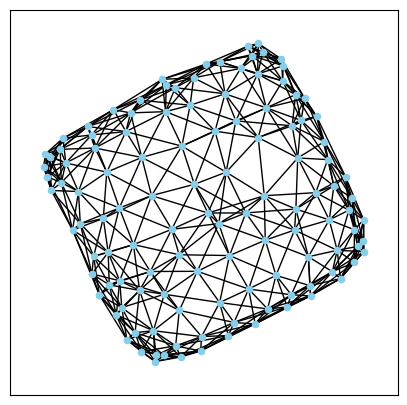

processing layer 0
head 1/4
head 2/4
head 3/4
head 4/4
processing layer 1
head 1/4
head 2/4
head 3/4
head 4/4
processing layer 2
head 1/4
head 2/4
head 3/4
head 4/4
processing layer 3
head 1/4
head 2/4
head 3/4
head 4/4
processing layer 4
head 1/4
head 2/4
head 3/4
head 4/4


: 

In [25]:
num_display_graphs = 1

edge_idxs = myFeatureExtractor.edge_idxs
for i in range(num_display_graphs):   
    # prepare input graph
    input_graph = nx.Graph()
    input_graph.add_edges_from(edge_idxs[i].t().tolist())
    print(input_graph.number_of_nodes())
    print(torch.max(edge_idxs[i]))
    pos = nx.spring_layout(input_graph)
    N = torch.max(edge_idxs[i])+1

    # plot input graph
    height = 5
    fig = plt.figure(figsize=(height, height))
    nx.draw_networkx_edges(input_graph, pos, edge_color='black', width=1)
    nx.draw_networkx_nodes(input_graph, pos, node_size=20, node_color='skyblue')
    plt.show()

    # prepare figure for plotting graphs
    num_layers = 5
    fig, axs = plt.subplots(num_layers, num_heads, figsize=((num_heads+0.2)*height,height*num_layers), gridspec_kw={'width_ratios': [1]*num_heads})
    plt.subplots_adjust(wspace=0, hspace=0)

    # fix captions
    for col in range(num_heads):
        axs[0, col].set_title(f"Head {col+1}", fontsize=20)
    for row in range(num_layers):
        axs[row, 0].set_ylabel(f"Layer {row}", rotation=90, x=-0.7, y=0.5, va='center', ha='center', fontsize=20)
    

    for layer_name in myFeatureExtractor.tokens.keys():
        token_list = myFeatureExtractor.tokens[layer_name]  # list of tensors, one for each graph
        label_list = myFeatureExtractor.labels[layer_name]  # list of tensors, one for each graph
        attn = myFeatureExtractor.attn_layers[layer_name]
        layer_num = int(layer_name.split('.')[-1])
        print("processing layer", layer_num)

        # [1, N, d]
        x = token_list[i]
        x = x.unsqueeze(0)
        
        if isinstance(attn, SparseAttention):
            num_heads = attn.num_heads
                
            # [1, num_heads, N, kq_dim]
            queries = attn.split_heads(attn.MQs(x), small_dim=attn.kq_dim)
            keys = attn.split_heads(attn.MKs(x), small_dim=attn.kq_dim)
            # [1, num_heads, N, val_dim]
            values = attn.split_heads(attn.MVs(x), small_dim=attn.val_dim)
            # [1, num_heads, N, k]
            nearest_key_indices = attn.nearest_k_keys(queries, keys)
            # the k keys nearest to each query
            # [1, num_heads, N, k, kq_dim]
            nearest_keys = torch.gather(
                input=keys.unsqueeze(-2).expand(
                    *keys.shape[:-1], attn.k, attn.kq_dim
                ),  # [**, num_heads, N, k, kq_dim]
                dim=-3,
                index=nearest_key_indices.unsqueeze(-1).expand(
                    *nearest_key_indices.shape, attn.kq_dim
                ),  # [**, num_heads, N, k, kq_dim]
                # sparse_grad=True,
            )
            # [1, num_heads, N, k, kq_dim]
            queries_extended = queries.unsqueeze(-2).expand(
                *queries.shape[:-1], attn.k, attn.kq_dim
            )
            # [1, num_heads, N, k]
            largest_attention_weights = (queries_extended * nearest_keys).sum(
                -1
            ) / math.sqrt(attn.kq_dim)
            # [1, num_heads, N, k]
            largest_attention_weights = F.softmax(largest_attention_weights, dim=-1)

            # for node coloring
            norm_node = plt.Normalize(vmin=0, vmax=N)
            cmap_node = plt.cm.plasma

            # plot the learnt graphs
            vis_mip_attn_graph_multiple_heads(
                pos,
                axs[layer_num],
                nearest_key_indices[0, :, :N],
                largest_attention_weights[0, :, :N],
                norm_node=norm_node,
                cmap_node=cmap_node
            )

    # plot the color bar
    # Add a color bar to show the mapping of weights to colors
    sm = plt.cm.ScalarMappable(cmap=cmap_node, norm=norm_node)
    sm.set_array([])  # Only needed for the colorbar
    cbar = plt.colorbar(sm, ax=axs, orientation='vertical', pad=0.02, aspect=40)
    cbar.set_label('Out-degree', fontsize=20)

    plt.show()

In [ ]:
norm = plt.Normalize(vmin=0, vmax=10)
norm(8)

0.8

In [ ]:
nearest_key_indices[0][0].shape
pred_adj_sparse = nearest_key_indices[0][0][:20]
print(pred_adj_sparse)

N, k = pred_adj_sparse.shape
m = 3

# get the top m incoming edges for each node
pred_edge_idx = torch.empty(2, N*m, dtype=torch.long, device=pred_adj_sparse.device)
for i, row in enumerate(pred_adj_sparse):
    pred_edge_idx[0, i*m:(i+1)*m] = row[:m]
    pred_edge_idx[1, i*m:(i+1)*m] = i

print(pred_edge_idx)

tensor([[ 48,  28,  82,   6,  61,  23,  14,  72,  17,  73],
        [ 39,  91,  27,  67, 109,  82,  49,  94,  74,   9],
        [ 91,  27, 109,  39,  67,  49,  74,  44,  94,  41],
        [ 82,  91,  61,  17,  67,  73,  98,  94,  41,   9],
        [ 83,  63,  51,  81,  32, 107,  90, 102,  21,  89],
        [ 91,  39, 109,  67,  27,  23,  49,  82,  94,  41],
        [ 69,  64, 106,   1,  13,  58,  65,  26,   5,  97],
        [ 48,  72,  28,  61,   6,  51,  73,  23,  92,  85],
        [ 48,  84,  14,  72,  67,  73,  91,  28,  82,  61],
        [ 72,  86,  58, 108,  13,  97,  26,   5,   1, 106],
        [ 58,  87,  68,   1,   2,  97,   5, 106,  65,  31],
        [ 85,  28,  37,  17,  92,  51,  12,  59,   3,  72],
        [ 17,  32,  83,  23,  82,  73,  81,  48,  98,  67],
        [ 91,  67,  39, 109,  27,  23,  82,  49,  94,  41],
        [ 72,  84,  28,  48,   6,  97,  58, 108,  57,  36],
        [ 91,  27, 109,  39,  49,  67,  44,  94,  82,  74],
        [ 82,  17,  67,  91,  48,   6,  

In [ ]:
def get_recall_at_m(input_edge_idx: torch.Tensor, pred_adj_sparse: torch.Tensor, m: int):
    """
    Assume that the input graph is directed. We want to find the fraction of true edges that were predicted, when only taking the top m incoming edges for each node.

    args:
        input_edge_idx: [2, E]
        pred_adj_sparse: [N,K]
        m: int
    returns:
        recall: float, fraction of true edges that were predicted
    """

    N, k = pred_adj_sparse.shape

    # get the top m incoming edges for each node
    pred_edge_idx = torch.empty(2, N*m, dtype=torch.long, device=pred_adj_sparse.device)
    for i, row in enumerate(pred_adj_sparse):
        pred_edge_idx[0, i*m:(i+1)*m] = row[:m]
        pred_edge_idx[1, i*m:(i+1)*m] = i

    # convert to sets
    input_edges = set([(input_edge_idx[0][i].item(), input_edge_idx[1][i].item()) for i in range(input_edge_idx.shape[-1])])
    pred_edges = set([(pred_edge_idx[0][i].item(), pred_edge_idx[1][i].item()) for i in range(pred_edge_idx.shape[-1])])

    # count the number of true edges that were predicted
    num_true_edges_predicted = len(input_edges.intersection(pred_edges))

    return num_true_edges_predicted / len(input_edges)

In [ ]:
# a matrix of [N, 10] where each row is a slice of a permutation of [0,1,...,N-1]
N, k = pred_adj_sparse.shape
pred_adj_random = torch.stack([torch.randperm(N)[:10] for _ in range(N)])

In [ ]:
pred_adj_sparse = nearest_key_indices[0][3]
print(get_recall_at_m(edge_idxs[0], pred_adj_sparse, 8))
print(get_recall_at_m(edge_idxs[0], pred_adj_random, 8))

0.06557377049180328
0.009221311475409836


head 1/4
head 2/4
head 3/4
head 4/4


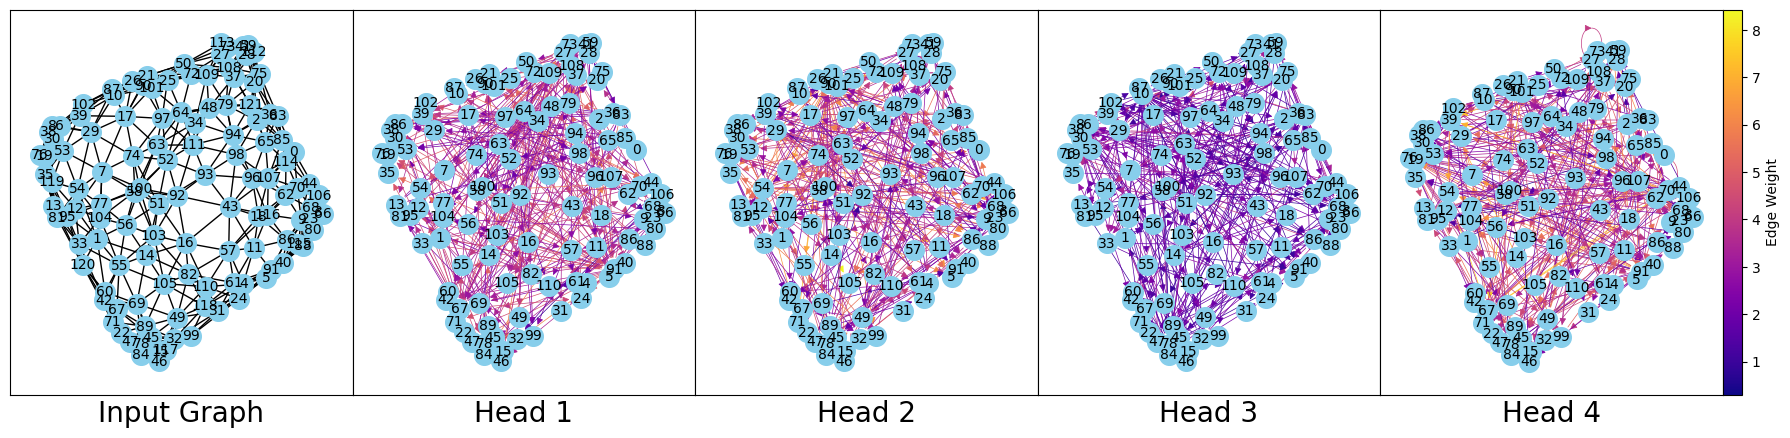

In [ ]:
fake_nodes = keys[0][0].norm(dim=-1) == keys[0][0].norm(dim=-1)[-1]

G = vis_mip_attn_graph_multiple_heads(nearest_key_indices[0, :, ~fake_nodes, :], largest_attention_weights[0, :, ~fake_nodes, :], edge_idxs[0])

{48: 39, 0: 1, 28: 23, 82: 46, 6: 26, 61: 17, 23: 35, 14: 16, 72: 23, 17: 19, 73: 20, 39: 40, 1: 48, 91: 51, 27: 42, 67: 50, 109: 30, 49: 20, 94: 37, 74: 6, 9: 14, 2: 35, 44: 7, 41: 24, 3: 3, 98: 12, 83: 12, 4: 2, 63: 8, 51: 9, 81: 7, 32: 13, 107: 4, 90: 4, 102: 3, 21: 2, 89: 2, 5: 32, 69: 17, 64: 27, 106: 42, 13: 23, 58: 47, 65: 31, 26: 32, 97: 33, 7: 0, 92: 17, 85: 13, 8: 3, 84: 17, 86: 10, 108: 9, 10: 2, 87: 31, 68: 19, 31: 9, 11: 0, 37: 7, 12: 2, 59: 3, 57: 10, 36: 3, 15: 8, 16: 0, 103: 14, 18: 7, 19: 3, 20: 1, 54: 3, 22: 0, 24: 0, 25: 0, 104: 6, 52: 1, 29: 0, 80: 1, 30: 0, 33: 1, 34: 7, 101: 6, 35: 1, 95: 1, 38: 0, 40: 3, 42: 0, 43: 0, 45: 0, 46: 0, 47: 0, 50: 1, 55: 4, 53: 0, 56: 0, 60: 0, 62: 0, 66: 0, 70: 0, 71: 1, 75: 0, 76: 0, 77: 0, 78: 2, 79: 0, 88: 0, 93: 0, 96: 0, 99: 0, 100: 0, 105: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0}
[(91, 51), (67, 50), (1, 48), (58, 47), (82, 46), (27, 42), 

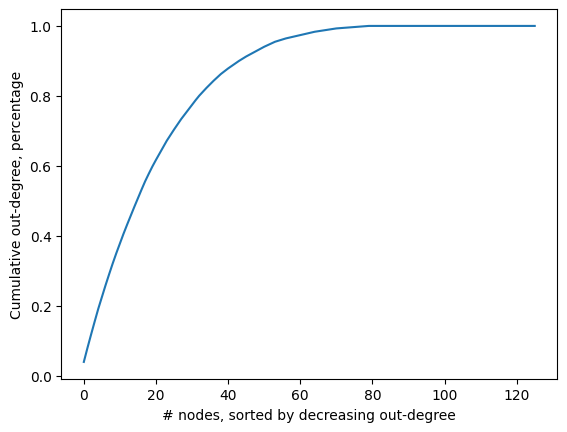

In [ ]:
N, k = nearest_key_indices[0][0].shape
G = nx.DiGraph()
for i in range(N):
    for m in range(k):
        weight = largest_attention_weights[0][0][i][m].item()
        G.add_edge(nearest_key_indices[0][0][i][m].item(), i, weight=weight)

out_degrees = dict(G.out_degree())
print(out_degrees)
sorted_out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
print(sorted_out_degrees)

# plot a graph that shows how much the out_degrees are concentrated in the nodes with the highest out_degree
# x-axis: percentage of nodes, y-axis: percentage of out_degree

out_degrees = [out_degrees[i] for i in range(len(out_degrees))]
out_degrees = sorted(out_degrees, reverse=True)
print(out_degrees)
print(sum(out_degrees))

cumulative_out_degrees = [sum(out_degrees[:i+1]) for i in range(len(out_degrees))]
cumulative_out_degrees = [x/sum(out_degrees) for x in cumulative_out_degrees]
print(cumulative_out_degrees)

plt.plot(cumulative_out_degrees)
plt.ylabel("Cumulative out-degree, percentage")
plt.xlabel("# nodes, sorted by decreasing out-degree")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Assume queries and keys are your input tensors of shape [N, D]
# Example:
# queries = torch.randn(100, 64)  # 100 embeddings of dimension 64
# keys = torch.randn(100, 64)     # 100 embeddings of dimension 64

# normalize largest_attention_weights[0][0] to get edge weights
edge_weights = largest_attention_weights[0][0].clone()
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Convert to NumPy arrays
queries_np = queries[0][0].detach().numpy()[~fake_nodes[0]]
keys_np = keys[0][0].detach().numpy()[~fake_nodes[0]]
nearest_key_indices_np = nearest_key_indices[0][0].numpy()[~fake_nodes[0]]

# Concatenate the queries and keys
embeddings = np.concatenate((queries_np, keys_np), axis=0)

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Split the PCA-transformed data back into queries and keys
queries_pca = embeddings_pca[:queries_np.shape[0], :]
keys_pca = embeddings_pca[queries_np.shape[0]:, :]
print(queries_pca.shape)
print(keys_pca.shape)

# Plot the PCA results
plt.figure(figsize=(8, 8))
plt.scatter(queries_pca[:, 0], queries_pca[:, 1], color='blue', label='Queries')
plt.scatter(keys_pca[:, 0], keys_pca[:, 1], color='red', label='Keys')
plt.title('PCA of Queries and Keys Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Draw arrows
for i in range(keys_pca.shape[0]):
    for m in range(nearest_key_indices_np.shape[1]):
        j = nearest_key_indices_np[i, m]
        plt.arrow(
            x=queries_pca[i, 0], y=queries_pca[i, 1],
            dx=keys_pca[j, 0] - queries_pca[i, 0], dy=keys_pca[j, 1] - queries_pca[i, 1],
            color='black', alpha=0.2 * edge_weights[i, m].item()
        )


plt.legend()
plt.grid(True)
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.6394249  -0.1375435  -0.6118493  -1.0891305  -0.09775627  1.2883383
 -1.5833609  -0.13725038 -0.08902983  0.03025507 -0.04374529  0.5300982
 -1.1957915   0.7256838  -0.33620727 -0.8546293   0.87173545  1.2065867
  0.6957994  -0.15201241 -1.5189583   0.9204835  -1.0077431  -1.3817191
  1.292079    0.42627686  0.7627423   1.2131135  -0.07170144  0.9691094
 -0.10905048  1.1352912   0.56661594  1.8194804  -0.98510134 -0.19240423
  2.0507681   0.6176064  -1.3476351  -2.485352   -0.19796667 -1.7331959
 -1.499969    1.289451    0.6634847  -0.08241898 -0.5804594  -0.32047886
 -2.1667717  -0.35405022 -3.381404   -1.0448949  -1.3554753   1.277675
  0.21115407 -1.1623365   0.81388277 -1.2138559  -2.3772664  -0.52125764
  0.8506644  -0.2973412  -0.8418564  -0.11482673  1.6680986   0.5073627
 -0.19313015  1.5263228   1.4592503  -1.0692271  -0.6971389  -2.050981
 -1.5501952  -2.0538154   0.5178174  -0.76728195 -0.43853366 -0.633644
 -2.5084083   1.7292079 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

: 

/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(105, 2)
(105, 2)


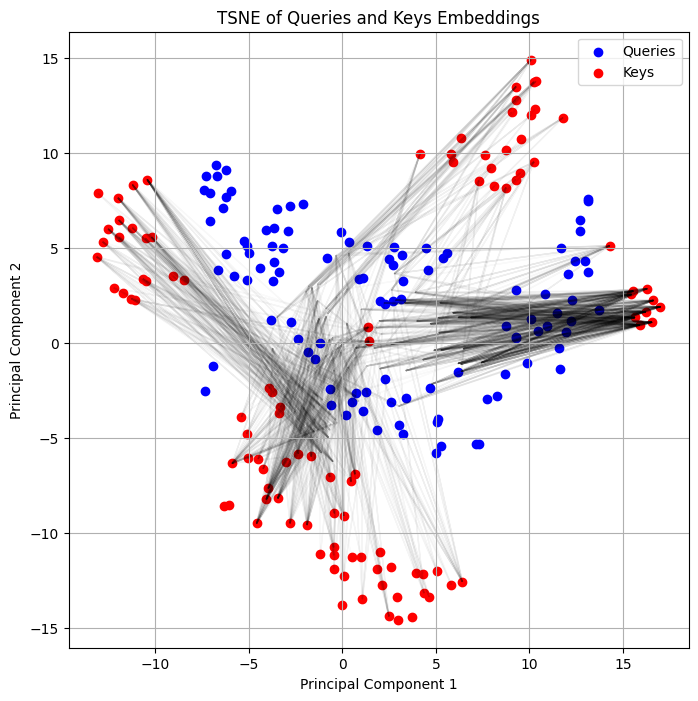

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Assume queries and keys are your input tensors of shape [N, D]
# Example:
# queries = torch.randn(100, 64)  # 100 embeddings of dimension 64
# keys = torch.randn(100, 64)     # 100 embeddings of dimension 64

# normalize largest_attention_weights[0][0] to get edge weights
edge_weights = largest_attention_weights[0][0].clone()
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Convert to NumPy arrays
queries_np = queries[0][0].detach().numpy()[:105]
keys_np = keys[0][0].detach().numpy()[:105]
nearest_key_indices_np = nearest_key_indices[0][0].numpy()[:105]

# Concatenate the queries and keys
embeddings = np.concatenate((queries_np, keys_np), axis=0)

# Apply PCA to reduce dimensions to 2D
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the PCA-transformed data back into queries and keys
queries_tsne = embeddings_tsne[:queries_np.shape[0], :]
keys_tsne = embeddings_tsne[queries_np.shape[0]:, :]
print(queries_tsne.shape)
print(keys_tsne.shape)

# Plot the PCA results
plt.figure(figsize=(8, 8))
plt.scatter(queries_tsne[:, 0], queries_tsne[:, 1], color='blue', label='Queries')
plt.scatter(keys_tsne[:, 0], keys_tsne[:, 1], color='red', label='Keys')
plt.title('TSNE of Queries and Keys Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Draw arrows
for i in range(keys_tsne.shape[0]):
    for m in range(nearest_key_indices_np.shape[1]):
        j = nearest_key_indices_np[i, m]
        plt.arrow(
            x=queries_pca[i, 0], y=queries_pca[i, 1],
            dx=keys_tsne[j, 0] - queries_pca[i, 0], dy=keys_tsne[j, 1] - queries_pca[i, 1],
            color='black', alpha=0.2 * edge_weights[i, m].item()
        )


plt.legend()
plt.grid(True)
plt.show()

array([[-1.3503120e+00, -2.6920779e+00],
       [-1.1446744e-01, -2.8154767e+00],
       [-1.2700746e+00, -4.5306916e+00],
       [ 2.0774260e+00,  5.4448932e-01],
       [-7.8135318e-01,  1.6186454e+00],
       [ 6.3725924e-01, -1.1259946e+00],
       [-1.8098649e+00, -1.1569797e+00],
       [ 2.3556910e+00,  5.8884542e-02],
       [-8.6776125e-01,  1.8420188e+00],
       [-3.0540937e-01, -1.2254201e-01],
       [ 1.7102467e+00, -3.0641237e-01],
       [-2.5304338e-01, -4.2112780e+00],
       [-4.0832877e-01, -1.9918108e+00],
       [ 1.1472456e+00,  7.8786135e-01],
       [-5.9990829e-01, -3.7235341e+00],
       [ 3.8859069e+00,  2.7274716e+00],
       [ 5.9173341e+00,  1.6083951e+00],
       [-2.8160753e+00, -3.1192584e+00],
       [ 7.4311531e-01, -3.8490510e-01],
       [ 7.4586072e+00, -1.0490401e+00],
       [-5.5819571e-01, -9.1974515e-01],
       [ 3.2942677e-01,  4.6966777e+00],
       [ 5.2910938e+00, -3.2766265e-01],
       [-2.3138641e-01,  3.0744085e-02],
       [ 1.84830

In [ ]:
for name, submodule in model.named_modules():
    num_params = sum(p.numel() for p in submodule.parameters())
    print(f"Submodule: {name}, Number of parameters: {num_params}")

Submodule: , Number of parameters: 209535
Submodule: encoder, Number of parameters: 680
Submodule: encoder.node_encoder, Number of parameters: 600
Submodule: encoder.node_encoder.encoder1, Number of parameters: 240
Submodule: encoder.node_encoder.encoder1.encoder, Number of parameters: 240
Submodule: encoder.node_encoder.encoder2, Number of parameters: 360
Submodule: encoder.node_encoder.encoder2.linear_encoder_eigenvec, Number of parameters: 360
Submodule: encoder.edge_encoder, Number of parameters: 80
Submodule: encoder.edge_encoder.encoder, Number of parameters: 80
Submodule: layers, Number of parameters: 206805
Submodule: layers.0, Number of parameters: 41361
Submodule: layers.0.local_model, Number of parameters: 8481
Submodule: layers.0.local_model.A, Number of parameters: 1640
Submodule: layers.0.local_model.B, Number of parameters: 1640
Submodule: layers.0.local_model.C, Number of parameters: 1640
Submodule: layers.0.local_model.D, Number of parameters: 1640
Submodule: layers.0.

: 